# Online Retail Simulator

This notebook provides a high-level overview of the [**Online Retail Simulator**](https://github.com/eisenhauerIO/tools-catalog-generator) and sets the context for the causal analyses that follow.

![description](online-retail-simulator.png)

The simulator operates in three phases. First, the **products** phase generates a product catalog with key attributes such as category and price tier. Second, the **product_details** phase enriches each product with detailed content including brand names, titles, descriptions, and feature lists. Third, the **metrics** phase simulates sales transactions with realistic temporal patterns and conversion metrics. You can choose between **rule-based generation**, which is deterministic and interpretable, and **synthesizer-based generation**, which learns patterns from your own data. An **enrichment layer** then allows you to inject known treatment effects—such as a quantity boost or a gradual rollout—so you can validate whether your causal models recover the true effect size.

## Simulate Product Data

We start by installing the package directly from its [GitHub](https://github.com/eisenhauerIO/tools-catalog-generator) repository. Then we are ready to import the **Online Retail Simulator** just as any other package.

In [ ]:
# Standard Library
import inspect

# Third-party packages
from IPython.display import Code
import pandas as pd

from online_retail_simulator import enrich, simulate, load_job_results

# Local imports
from support import (
    plot_revenue_by_category,
    plot_daily_metrics_trend,
    plot_conversion_funnel,
    plot_treatment_effect,
    display_product_details,
)

Let's start by simulating 100 products. The configuration is defined using [YAML](https://yaml.org/) and organizes the three-phase simulation process.

The **STORAGE** section specifies where to save output files.

The **RULE** section contains two subsections—**PRODUCTS** and **METRICS**—each defining a `FUNCTION` to call and a `PARAMS` subsection for function-specific parameters like `num_products`, `date_start`, `date_end`, and `seed`.

The **PRODUCT_DETAILS** section specifies the `FUNCTION` used to enrich products with additional content.

In [2]:
! cat "config_simulation.yaml"

STORAGE:
  PATH: output

RULE:
  PRODUCTS:
    FUNCTION: simulate_products_rule_based
    PARAMS:
      num_products: 100
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-01"
      date_end: "2024-11-30"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock


To understand how the simulation functions work under the hood, you can explore their source code directly. Python's `inspect` module lets you view the implementation right inside the notebook, or you can browse the source files on GitHub ([products](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/products_rule_based.py), [product_details](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/product_details_mock.py), [metrics](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/metrics_rule_based.py)) or the API documentation ([products](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/products_rule_based.html#simulate_products_rule_based), [product_details](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/product_details.html#simulate_product_details_mock), [metrics](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/metrics_rule_based.html#simulate_metrics_rule_based)).

In [ ]:
from online_retail_simulator.simulate.products_rule_based import simulate_products_rule_based

Code(inspect.getsource(simulate_products_rule_based), language="python")

In [ ]:
from online_retail_simulator.simulate.product_details_mock import simulate_product_details_mock

Code(inspect.getsource(simulate_product_details_mock), language="python")

Calling `simulate("config_simulation.yaml")` triggers a three-phase data generation process. First, it reads and validates the YAML configuration, then runs the **products** phase to create a product catalog with the specified number of products, assigning each a unique identifier, category, and price. Second, it runs the **product_details** phase to enrich each product with brand names, titles, descriptions, and feature lists. Third, it runs the **metrics** phase, simulating a shopper conversion funnel (impressions, visits, cart additions, orders, and revenue) for each product across the defined date range. The function writes the generated `DataFrame`s to disk and returns a `JobInfo` object that tracks where the results are stored—which you then pass to `load_job_results()` to retrieve the data.

The products data represents the catalog of items available for sale. Each product starts with core **attributes**—a unique `product_identifier`, `category` (such as Electronics, Clothing, or Books), `brand`, and `price`—which are then enriched with **product_details** including `title`, `description`, and `features`. These attributes influence the simulated sales behavior—for example, higher-priced items may have different conversion patterns than low-cost products, and categories can exhibit distinct purchasing dynamics.

In [ ]:
job_info = simulate("config_simulation.yaml")

results = load_job_results(job_info)
products = results["products"]
metrics = results["metrics"]

### Products

In [6]:
products.head()

,product_identifier,category,price,title,description,brand,features
0,BRPOIG8F1C,Clothing,19.63,StyleFit Premium Clothing Item,Quality clothing product for everyday use. Bre...,StyleFit,"['Breathable fabric', 'Stretch fit', 'Wrinkle ..."
1,BO6B9M80O2,Electronics,185.86,SmartLife Pro Electronics Item,Quality electronics product for everyday use. ...,SmartLife,"['Voice control', 'Long battery life', 'Fast c..."
2,BAK1VRJNVG,Sports & Outdoors,245.69,BestChoice Classic Sports & Outdoors Item,Quality sports & outdoors product for everyday...,BestChoice,"['Great value', 'Easy to use', 'Durable constr..."
3,BWWQC38HYF,Clothing,85.29,StyleFit Premium Clothing Item,Quality clothing product for everyday use. Wri...,StyleFit,"['Wrinkle resistant', 'Breathable fabric', 'Ma..."
4,BXMECOSFOG,Sports & Outdoors,251.38,TrustMark Quality Sports & Outdoors Item,Quality sports & outdoors product for everyday...,TrustMark,"['Easy to use', 'Long lasting', 'Great value',..."


Let's examine a single product to understand the structure better.

In [7]:
example_product = products.iloc[0]
example_product

product_identifier                                           BRPOIG8F1C
category                                                       Clothing
price                                                             19.63
title                                    StyleFit Premium Clothing Item
description           Quality clothing product for everyday use. Bre...
brand                                                          StyleFit
features              ['Breathable fabric', 'Stretch fit', 'Wrinkle ...
Name: 0, dtype: object

This product has a unique `product_identifier` for tracking, belongs to the `category` Clothing with a `price` of $19.63, and includes enriched content: a `brand` name (StyleFit), a descriptive `title`, a marketing-focused `description`, and a list of product `features`. These attributes combine catalog characteristics with content details to create a realistic product listing.

### Metrics

In [8]:
metrics.sort_values(["product_identifier", "date"]).head()

,product_identifier,category,price,title,description,brand,features,date,impressions,visits,cart_adds,ordered_units,revenue
24,B07UQNUPQZ,Electronics,948.1,TechPro Ultra Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Long battery life', 'Blueto...",2024-11-01,10,1,0,0,0.0
124,B07UQNUPQZ,Electronics,948.1,TechPro Ultra Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Long battery life', 'Blueto...",2024-11-02,10,1,0,0,0.0
224,B07UQNUPQZ,Electronics,948.1,TechPro Ultra Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Long battery life', 'Blueto...",2024-11-03,10,1,0,0,0.0
324,B07UQNUPQZ,Electronics,948.1,TechPro Ultra Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Long battery life', 'Blueto...",2024-11-04,50,6,1,0,0.0
424,B07UQNUPQZ,Electronics,948.1,TechPro Ultra Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Long battery life', 'Blueto...",2024-11-05,25,4,0,0,0.0


Let's examine a single metric record to understand the conversion funnel structure.

In [9]:
example_metric = metrics.iloc[0]
example_metric

product_identifier                                           BRPOIG8F1C
category                                                       Clothing
price                                                             19.63
title                                    StyleFit Premium Clothing Item
description           Quality clothing product for everyday use. Bre...
brand                                                          StyleFit
features              ['Breathable fabric', 'Stretch fit', 'Wrinkle ...
date                                                         2024-11-01
impressions                                                          10
visits                                                                1
cart_adds                                                             0
ordered_units                                                         0
revenue                                                             0.0
Name: 0, dtype: object

This metric record tracks the shopper journey as a conversion funnel for one product on one date. It includes `product_identifier`, `category`, and `date` for identification, then follows shoppers through each stage: `impressions` (product shown), `visits` (clicked to view), `cart_adds` (added to cart), `ordered_units` (purchased), and `revenue` (total sales). This funnel structure captures how shoppers drop off at each stage of the purchase process.

### Exploration

Now that we understand the structure of both DataFrames, let's explore the generated data through visualizations and summary statistics.

<div class="alert alert-block alert-info">
<b>Questions</b>
<ul>
    <li>What is the date range?</li>
    <li>How many categories?</li>
    <li>What is the total revenue?</li>
</ul>
</div>

How is revenue distributed across product categories?

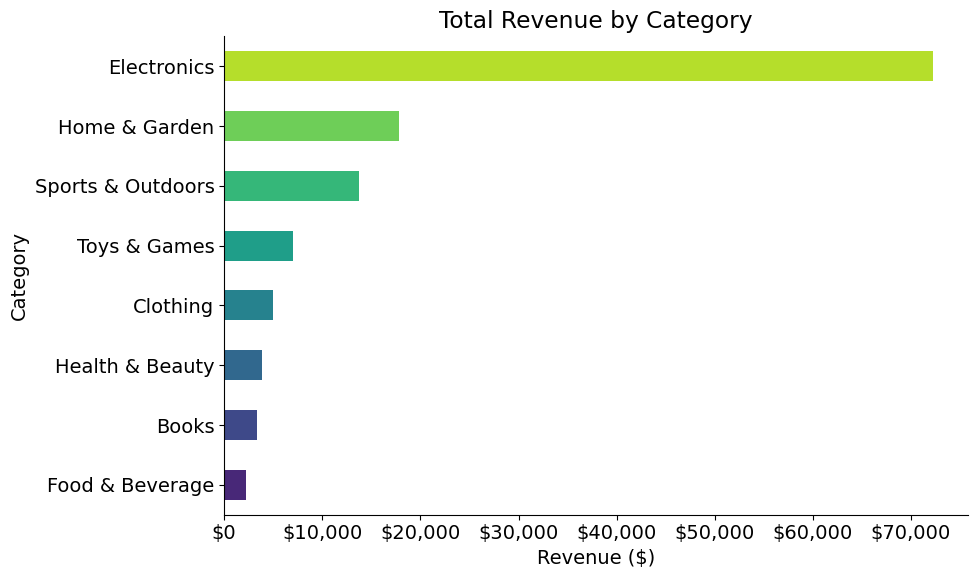

In [10]:
category_revenue = metrics.groupby("category")["revenue"].sum().sort_values()
plot_revenue_by_category(category_revenue)

In [11]:
Code(inspect.getsource(plot_revenue_by_category), language="python")

def plot_revenue_by_category(category_revenue):
    """
    Plot horizontal bar chart of revenue by category.

    Parameters
    ----------
    category_revenue : pandas.Series
        Series with category names as index and revenue values.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    category_revenue.plot(kind="barh", ax=ax, color=sns.color_palette("viridis", len(category_revenue)))
    ax.set_xlabel("Revenue ($)")
    ax.set_ylabel("Category")
    ax.set_title("Total Revenue by Category")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
    plt.tight_layout()
    plt.show()

How do metrics vary over time?

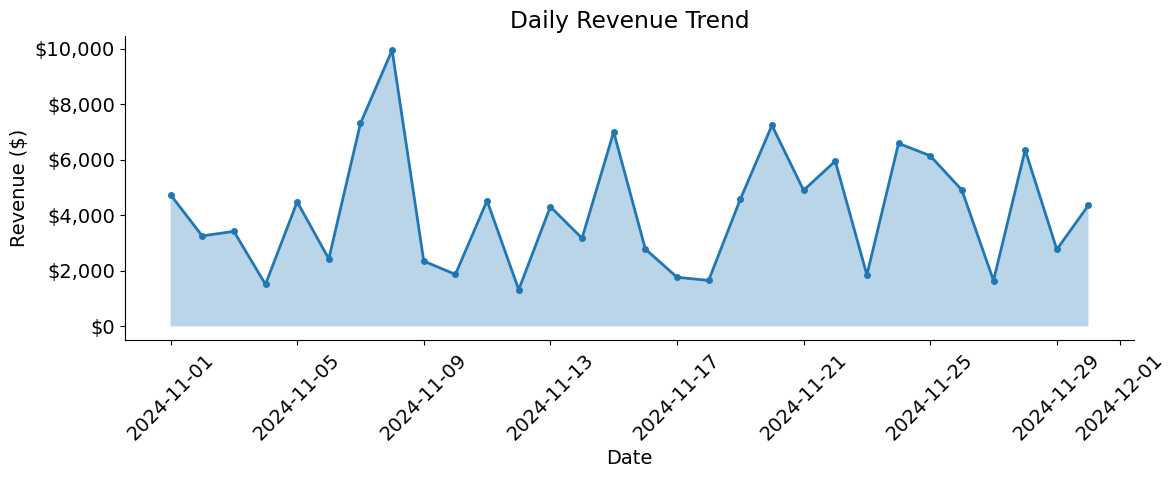

In [12]:
daily_metrics = metrics.groupby("date").agg({"ordered_units": "sum", "revenue": "sum"}).reset_index()
plot_daily_metrics_trend(daily_metrics)

How do shoppers move through the purchase journey?

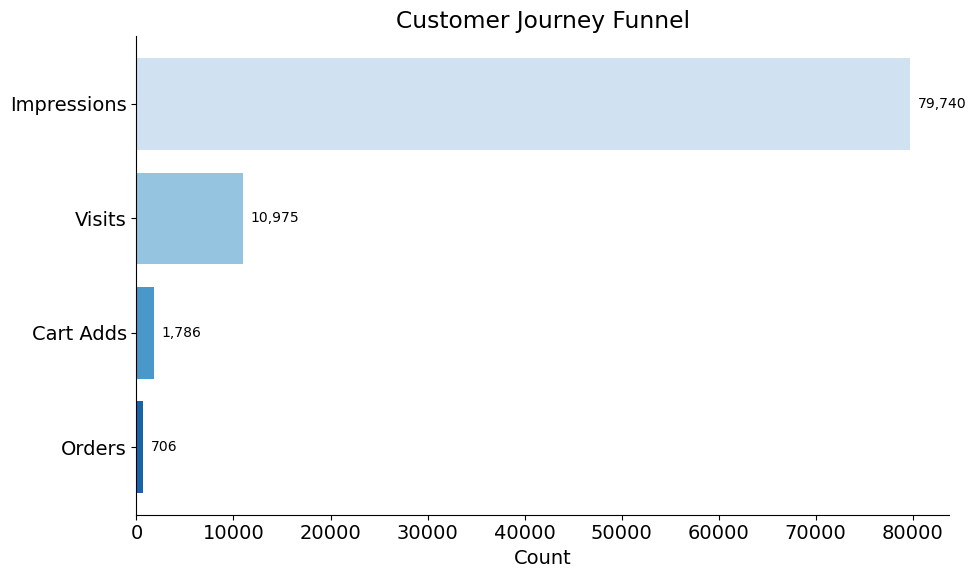

In [13]:
plot_conversion_funnel(metrics)

<div class="alert alert-block alert-info">
<b>Questions</b>
<ul>
    <li>What fraction of impressions become visits?</li>
    <li>What fraction of visits add to cart?</li>
    <li>What fraction of cart adds become orders?</li>
    <li>What is the overall conversion rate?</li>
</ul>
</div>

## Explore Product Data

**Vibe coding** is a development style where you describe *what* you want in natural language and let AI assistants generate the code. Rather than manually writing every line, you focus on asking the right questions and guiding the output. This approach accelerates exploratory data analysis, letting you iterate quickly through hypotheses without getting bogged down in syntax.

In this section, we use [GitHub Copilot](https://github.com/features/copilot) to generate descriptive plots on the fly. We ask a question, sketch the intent, and let Copilot fill in the details. The goal is not perfectly polished code—it's rapid insight generation. Once we find something interesting, we can refine and formalize it later.

**Revenue Analysis**

* Which category generates the most revenue?
* What are the top 10 products by revenue?
* How does daily revenue change over time?

**Product Performance**

* Which products have the most impressions but lowest conversion?
* What is the distribution of ordered units per product?

## Enrich Product Data

Real-world e-commerce teams constantly face a critical question: **Does improving product content quality increase sales?** To help you explore this with known ground truth, the simulator lets you inject treatment effects into a subset of products starting at a specific date, creating synthetic experiments where you know the true causal impact.

The enrichment process operates through two coordinated mechanisms:

1. **Content Enhancement**: Generate upgraded product copy with premium brand positioning, compelling descriptions, and detailed feature highlights
2. **Sales Impact**: Apply the corresponding sales boost that this improved content would realistically produce

The **ENRICHMENT** configuration controls the treatment parameters. The `effect_size` controls the magnitude of the boost (0.5 = 50% increase), `enrichment_fraction` determines what share of products receive treatment (1.0 = 100%), and `enrichment_start` sets when the intervention begins. The `ramp_days` parameter models a gradual rollout where the effect linearly increases over the specified number of days, mimicking real-world deployment patterns.

In [ ]:
! cat "config_enrichment.yaml"

In [15]:
from online_retail_simulator.enrich.enrichment_library import product_detail_boost

Code(inspect.getsource(product_detail_boost), language="python")

def product_detail_boost(sales: list, **kwargs) -> tuple:
    """
    Product detail regeneration and sales boost for enrichment experiments.

    Selects a fraction of products for treatment, regenerates their product
    details (title, description, features) while preserving brand/category/price,
    and applies sales boost effect.

    Args:
        sales: List of sale transaction dictionaries
        **kwargs: Parameters including:
            - job_info: JobInfo for saving product artifacts (required for saving)
            - products: List of product dictionaries (required for product details)
            - effect_size: Percentage increase in ordered units (default: 0.5)
            - ramp_days: Number of days for ramp-up period (default: 7)
            - enrichment_fraction: Fraction of products to enrich (default: 0.3)
            - enrichment_start: Start date of enrichment (default: "2024-11-15")
            - seed: Random seed for product selection (default: 42)
            - prompt_path: Path to custom prompt template file (optional)
            - backend: Backend to use for regeneration ("mock" or "ollama", default: "mock")

    Returns:
        Tuple of (treated_sales, potential_outcomes_df):
            - treated_sales: List of modified sale dictionaries with treatment applied
            - potential_outcomes_df: DataFrame with Y0_revenue and Y1_revenue for all products
    """
    job_info = kwargs.get("job_info")
    products = kwargs.get("products")
    effect_size = kwargs.get("effect_size", 0.5)
    ramp_days = kwargs.get("ramp_days", 7)
    enrichment_fraction = kwargs.get("enrichment_fraction", 0.3)
    enrichment_start = kwargs.get("enrichment_start", "2024-11-15")
    seed = kwargs.get("seed", 42)
    prompt_path = kwargs.get("prompt_path")
    backend = kwargs.get("backend", "mock")

    if seed is not None:
        random.seed(seed)

    # 1. Save original product details
    if job_info and products:
        job_info.save_df("product_details_original", pd.DataFrame(products))

    # 2. Select treatment products
    if products:
        unique_product_ids = list(set(p.get("product_identifier", p.get("product_id")) for p in products))
    else:
        unique_product_ids = list(set(sale["product_id"] for sale in sales))

    n_treatment = int(len(unique_product_ids) * enrichment_fraction)
    treatment_ids = set(random.sample(unique_product_ids, n_treatment))

    # 3. Regenerate product details for treatment products
    if products and job_info:
        updated_products = _regenerate_product_details(products, treatment_ids, prompt_path, backend, seed)
        job_info.save_df("product_details_enriched", pd.DataFrame(updated_products))

    # 4. Apply sales boost effect and calculate potential outcomes
    treated_sales = []
    potential_outcomes = {}  # {(product_id, date): {'Y0_revenue': x, 'Y1_revenue': y}}
    start_date = datetime.strptime(enrichment_start, "%Y-%m-%d")

    for sale in sales:
        sale_copy = copy.deepcopy(sale)
        product_id = sale_copy.get("product_id", sale_copy.get("product_identifier"))
        sale_date_str = sale_copy["date"]
        sale_date = datetime.strptime(sale_date_str, "%Y-%m-%d")

        is_enriched = product_id in treatment_ids
        sale_copy["enriched"] = is_enriched

        # Calculate Y(0) - baseline revenue (no treatment)
        y0_revenue = sale_copy["revenue"]

        # Calculate Y(1) - revenue if treated (for ALL products, with ramp-up)
        unit_price = sale_copy.get("unit_price", sale_copy.get("price"))
        if sale_date >= start_date:
            days_since_start = (sale_date - start_date).days
            ramp_factor = 1.0 if ramp_days <= 0 else min(1.0, days_since_start / ramp_days)
            adjusted_effect = effect_size * ramp_factor

            original_quantity = sale_copy["ordered_units"]
            boosted_quantity = int(original_quantity * (1 + adjusted_effect))
            y1_revenue = round(boosted_quantity * unit_

Calling `enrich("config_enrichment.yaml", job_info)` applies the treatment effect to the simulated data. The `product_detail_boost()` function performs two operations: first, it regenerates product details for the treatment group using `treatment_mode=True` (creating enhanced content with premium brand names, compelling descriptions, and specific feature highlights); second, it applies a 50% sales boost to these products starting November 15th. The function automatically saves three artifacts: the original product details, the enhanced treatment product details, and the enriched sales data—which we can load and examine to understand both the content improvements and their impact on sales metrics.

In [ ]:
enriched_job = enrich("config_enrichment.yaml", job_info)
results = load_job_results(enriched_job)

### Changes

In [17]:
enriched = results["enriched"]
enriched.head()

,product_identifier,category,price,title,description,brand,features,date,impressions,visits,cart_adds,ordered_units,revenue,enriched
0,BRPOIG8F1C,Clothing,19.63,StyleFit Premium Clothing Item,Quality clothing product for everyday use. Bre...,StyleFit,"['Breathable fabric', 'Stretch fit', 'Wrinkle ...",2024-11-01,10,1,0,0,0.00,True
1,BO6B9M80O2,Electronics,185.86,SmartLife Pro Electronics Item,Quality electronics product for everyday use. ...,SmartLife,"['Voice control', 'Long battery life', 'Fast c...",2024-11-01,0,0,0,0,0.00,True
2,BAK1VRJNVG,Sports & Outdoors,245.69,BestChoice Classic Sports & Outdoors Item,Quality sports & outdoors product for everyday...,BestChoice,"['Great value', 'Easy to use', 'Durable constr...",2024-11-01,100,12,2,1,245.69,True
3,BWWQC38HYF,Clothing,85.29,StyleFit Premium Clothing Item,Quality clothing product for everyday use. Wri...,StyleFit,"['Wrinkle resistant', 'Breathable fabric', 'Ma...",2024-11-01,25,3,0,0,0.00,True
4,BXMECOSFOG,Sports & Outdoors,251.38,TrustMark Quality Sports & Outdoors Item,Quality sports & outdoors product for everyday...,TrustMark,"['Easy to use', 'Long lasting', 'Great value',...",2024-11-01,25,3,0,0,0.00,True


The enriched dataset contains the same metrics as before (`impressions`, `visits`, `cart_adds`, `ordered_units`, `revenue`) but now includes an `enriched` column indicating which products received the treatment. Products with `enriched=True` have enhanced content and boosted sales metrics starting from the treatment date.

In [18]:
example_enriched = enriched.iloc[0]
example_enriched

product_identifier                                           BRPOIG8F1C
category                                                       Clothing
price                                                             19.63
title                                    StyleFit Premium Clothing Item
description           Quality clothing product for everyday use. Bre...
brand                                                          StyleFit
features              ['Breathable fabric', 'Stretch fit', 'Wrinkle ...
date                                                         2024-11-01
impressions                                                          10
visits                                                                1
cart_adds                                                             0
ordered_units                                                         0
revenue                                                             0.0
enriched                                                        

This record shows all the sales funnel metrics plus the `enriched` indicator. The treatment assignment is random but deterministic (controlled by the `seed` parameter), allowing us to create a reproducible experiment where we know the ground truth effect size.

The enrichment process modifies both sales metrics and product content. Let's compare the original and enhanced product details to see the transformation.

In [ ]:
control_products = results["product_details_original"]
control_example = control_products.iloc[0]

display_product_details(control_example, "CONTROL GROUP (Original Content)")

In [ ]:
treatment_products = results["product_details_enriched"]
treatment_example = treatment_products.iloc[0]

display_product_details(treatment_example, "TREATMENT GROUP (Enhanced Content)", add_newline=True)

<div class="alert alert-block alert-info">
<b>Questions</b>
<ul>
    <li>What differences do you notice in brand names?</li>
    <li>How do the titles differ between control and treatment?</li>
    <li>What makes the treatment description more compelling?</li>
    <li>How are the features enhanced in the treatment version?</li>
</ul>
</div>

### Impact

The treatment effect visualization compares daily revenue between the original and enriched datasets. Before the treatment start date, the lines should overlap perfectly. After November 15th, the enriched dataset should show higher revenue due to the 50% boost applied to all products.

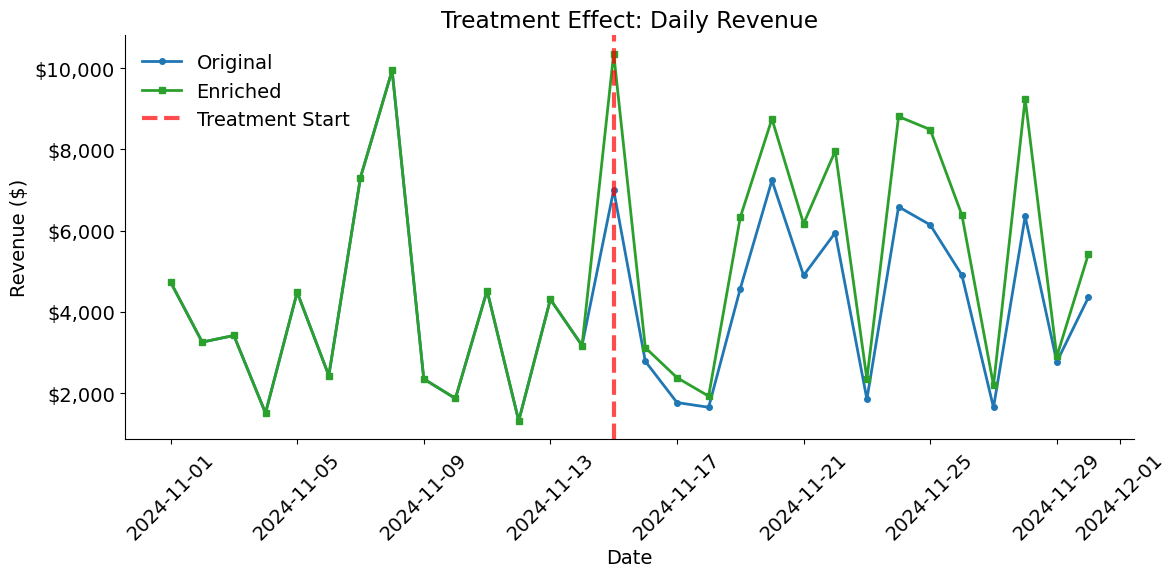

In [21]:
plot_treatment_effect(metrics, enriched, "2024-11-15")